# Evaluación de Técnicas de Prompt Engineering para RAG Fintech

Este notebook implementa una evaluación dual usando:
- **LLM-as-a-Judge**: Evaluación semántica customizada con métricas específicas de fintech
- **RAGAS**: Framework estándar para evaluación de sistemas RAG

**Técnicas evaluadas:**
1. Prompt básico con contexto
2. Prompt con rol específico  
3. One-shot learning
4. Chain-of-thought

## 1. Configuración y Dependencias

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pickle
from datetime import datetime
from typing import List, Dict, Any
from dotenv import load_dotenv
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_precision, answer_correctness
from datasets import Dataset

from evaluation_dataset import get_questions_by_category
from prompts_fintech import get_all_prompts, PROMPT_LLM_JUDGE

warnings.filterwarnings('ignore')
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
assert openai_api_key, "⚠️ Falta configurar OPENAI_API_KEY en .env"

## 2. Carga de Datos y Configuración del Sistema RAG

In [2]:
# Estos documentos (chunks) vienen de la notebook que sirvió como PoC de los prompts básicos
# La notebook es: 01_rag_prompt_testing.ipynb

with open('documents.pkl', 'rb') as f:
    documents = pickle.load(f)

embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
vectorstore = FAISS.from_documents(documents, embeddings)

# Esta es la LLM que voy a utilizar para responder las preguntas
llm = ChatOpenAI(temperature=0.3, openai_api_key=openai_api_key, model="gpt-3.5-turbo")

prompts = get_all_prompts()

print(f"Documentos cargados: {len(documents)}")
print(f"Prompts a evaluar: {list(prompts.keys())}")

Documentos cargados: 33
Prompts a evaluar: ['basico', 'con_rol', 'one_shot', 'chain_of_thought']


## 3. Dataset de Evaluación

In [3]:
debito_questions = get_questions_by_category("tarjeta_debito")
credito_questions = get_questions_by_category("tarjeta_credito")
prestamo_questions = get_questions_by_category("prestamo")

test_questions = debito_questions + credito_questions + prestamo_questions

for i, q in enumerate(test_questions):
    q['id'] = i + 1

print(f"Dataset configurado:")
print(f"   • Tarjeta débito: {len(debito_questions)} preguntas")
print(f"   • Tarjeta crédito: {len(credito_questions)} preguntas")
print(f"   • Préstamos: {len(prestamo_questions)} preguntas")
print(f"   • Total: {len(test_questions)} preguntas")
print(f"   • Evaluaciones totales: {len(test_questions) * len(prompts)}")

Dataset configurado:
   • Tarjeta débito: 5 preguntas
   • Tarjeta crédito: 6 preguntas
   • Préstamos: 9 preguntas
   • Total: 20 preguntas
   • Evaluaciones totales: 80


## 4. Funciones de Evaluación

### 4.1 Sistema RAG

In [4]:
def rag_query(question: str, prompt_template: str, k: int = 3) -> Dict[str, Any]:
    docs = vectorstore.similarity_search(question, k=k)
    contexts = [doc.page_content for doc in docs]
    context = "\n\n".join(contexts)
    
    prompt = prompt_template.format(context=context, question=question)
    response = llm.invoke(prompt).content
    
    return {
        "question": question,
        "contexts": contexts,
        "answer": response,
        "prompt_used": prompt_template
    }

### 4.2 LLM-as-a-Judge

In [5]:
class LLMJudgeResult(BaseModel):
    empathy_score: float
    empathy_reasoning: str
    technical_accuracy_score: float
    technical_accuracy_reasoning: str
    completeness_score: float
    completeness_reasoning: str
    faithfulness_score: float
    faithfulness_reasoning: str
    overall_score: float

def evaluate_prompt_on_questions(prompt_name: str, prompt_template: str, test_questions: List[Dict]) -> List[Dict]:
    llm_judge = ChatOpenAI(
        temperature=0.1,
        model="gpt-3.5-turbo",
        openai_api_key=openai_api_key
    ).with_structured_output(LLMJudgeResult)
    
    results = []
    
    print(f"   Evaluando {len(test_questions)} preguntas con '{prompt_name}'")
    
    for i, question_data in enumerate(test_questions, 1):
        print(f"   Q{i}: ", end="")
        
        rag_result = rag_query(question_data['question'], prompt_template)
        context_str = "\n".join(rag_result['contexts'])
        
        judge_prompt = PROMPT_LLM_JUDGE.format(
            question=question_data['question'],
            response=rag_result['answer'],
            ideal_answer=question_data['ideal_answer'],
            context=context_str,
            category=question_data['category']
        )
        
        evaluation = llm_judge.invoke(judge_prompt)
        
        result = {
            'question_id': question_data['id'],
            'question': question_data['question'],
            'category': question_data['category'],
            'prompt_version': prompt_name,
            'response': rag_result['answer'],
            'context': rag_result['contexts'],
            'ideal_answer': question_data['ideal_answer'],
            'evaluation': evaluation.dict(),
            'overall_score': evaluation.overall_score
        }
        
        results.append(result)
        print(f"Score: {evaluation.overall_score:.2f}/5.0")
    
    return results

### 4.3 Evaluación RAGAS

In [6]:
def evaluate_with_ragas(prompt_name: str, results: List[Dict]) -> Dict[str, float]:
    print(f"   Evaluando {prompt_name} con RAGAS...")
    
    ragas_data = {
        'question': [r['question'] for r in results],
        'answer': [r['response'] for r in results], 
        'contexts': [r['context'] for r in results],
        'ground_truth': [r['ideal_answer'] for r in results]
    }
    
    dataset = Dataset.from_dict(ragas_data)
    
    metrics = [answer_relevancy, faithfulness, context_precision, answer_correctness]
    
    try:
        evaluation_result = evaluate(dataset=dataset, metrics=metrics)
        
        ragas_scores = {
            'answer_relevancy': np.mean(evaluation_result['answer_relevancy']),
            'faithfulness': np.mean(evaluation_result['faithfulness']), 
            'context_precision': np.mean(evaluation_result['context_precision']),
            'answer_correctness': np.mean(evaluation_result['answer_correctness'])
        }
        
        print(f"   RAGAS completado para {prompt_name}")
        return ragas_scores
        
    except Exception as e:
        print(f"   Error en RAGAS para {prompt_name}: {e}")
        return {
            'answer_relevancy': 0.0,
            'faithfulness': 0.0,
            'context_precision': 0.0, 
            'answer_correctness': 0.0
        }

## 5. Ejecución del Experimento

### 5.1 Evaluación LLM-as-a-Judge

In [7]:
print(" Ejecutando experimento LLM-as-a-Judge")
print("="*60)

all_results = {}
    
for prompt_name, prompt_template in prompts.items():
    print(f"\n {prompt_name.upper()}")
    
    prompt_results = evaluate_prompt_on_questions(prompt_name, prompt_template, test_questions)
    all_results[prompt_name] = prompt_results
    
    avg_score = sum(r['overall_score'] for r in prompt_results) / len(prompt_results)
    print(f"   Promedio: {avg_score:.2f}/5.0")

print(f"\n Evaluación LLM-as-a-Judge completada")

 Ejecutando experimento LLM-as-a-Judge

 BASICO
   Evaluando 20 preguntas con 'basico'
   Q1: Score: 2.50/5.0
   Q2: Score: 3.50/5.0
   Q3: Score: 4.50/5.0
   Q4: Score: 3.50/5.0
   Q5: Score: 4.50/5.0
   Q6: Score: 3.25/5.0
   Q7: Score: 3.50/5.0
   Q8: Score: 3.50/5.0
   Q9: Score: 3.50/5.0
   Q10: Score: 3.50/5.0
   Q11: Score: 3.50/5.0
   Q12: Score: 4.00/5.0
   Q13: Score: 4.50/5.0
   Q14: Score: 4.50/5.0
   Q15: Score: 3.50/5.0
   Q16: Score: 4.00/5.0
   Q17: Score: 4.25/5.0
   Q18: Score: 3.50/5.0
   Q19: Score: 4.50/5.0
   Q20: Score: 4.25/5.0
   Promedio: 3.81/5.0

 CON_ROL
   Evaluando 20 preguntas con 'con_rol'
   Q1: Score: 2.50/5.0
   Q2: Score: 4.00/5.0
   Q3: Score: 3.75/5.0
   Q4: Score: 3.75/5.0
   Q5: Score: 3.50/5.0
   Q6: Score: 3.50/5.0
   Q7: Score: 3.75/5.0
   Q8: Score: 4.00/5.0
   Q9: Score: 3.75/5.0
   Q10: Score: 4.50/5.0
   Q11: Score: 4.00/5.0
   Q12: Score: 3.50/5.0
   Q13: Score: 4.50/5.0
   Q14: Score: 4.50/5.0
   Q15: Score: 3.75/5.0
   Q16: Score: 3.50

### 5.2 Evaluación RAGAS

In [8]:
print("🚀 Ejecutando evaluación RAGAS complementaria")
print("="*60)

ragas_results = {}

for prompt_name, prompt_results in all_results.items():
    print(f"\n📊 {prompt_name.upper()}")
    
    ragas_scores = evaluate_with_ragas(prompt_name, prompt_results)
    ragas_results[prompt_name] = ragas_scores
    
    print(f"   Relevancia: {ragas_scores['answer_relevancy']:.3f}")
    print(f"   Fidelidad: {ragas_scores['faithfulness']:.3f}")
    print(f"   Precisión: {ragas_scores['context_precision']:.3f}")
    print(f"   Correctitud: {ragas_scores['answer_correctness']:.3f}")

print(f"\n🎯 Evaluación RAGAS completada")

🚀 Ejecutando evaluación RAGAS complementaria

📊 BASICO
   Evaluando basico con RAGAS...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   RAGAS completado para basico
   Relevancia: 0.838
   Fidelidad: 0.968
   Precisión: 0.821
   Correctitud: 0.616

📊 CON_ROL
   Evaluando con_rol con RAGAS...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   RAGAS completado para con_rol
   Relevancia: 0.861
   Fidelidad: 0.671
   Precisión: 0.858
   Correctitud: 0.671

📊 ONE_SHOT
   Evaluando one_shot con RAGAS...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   RAGAS completado para one_shot
   Relevancia: 0.894
   Fidelidad: 0.731
   Precisión: 0.862
   Correctitud: 0.625

📊 CHAIN_OF_THOUGHT
   Evaluando chain_of_thought con RAGAS...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   RAGAS completado para chain_of_thought
   Relevancia: 0.848
   Fidelidad: 0.683
   Precisión: 0.937
   Correctitud: 0.635

🎯 Evaluación RAGAS completada


## 6. Análisis de Resultados

### 6.1 Resumen LLM-as-a-Judge

In [9]:
print("📊 RESUMEN LLM-AS-A-JUDGE")
print("="*50)

for prompt_name, results in all_results.items():
    empathy_avg = sum(r['evaluation']['empathy_score'] for r in results) / len(results)
    technical_avg = sum(r['evaluation']['technical_accuracy_score'] for r in results) / len(results)
    completeness_avg = sum(r['evaluation']['completeness_score'] for r in results) / len(results)
    faithfulness_avg = sum(r['evaluation']['faithfulness_score'] for r in results) / len(results)
    overall_avg = sum(r['overall_score'] for r in results) / len(results)
    
    print(f"\n🔸 {prompt_name.upper()}")
    print(f"   General: {overall_avg:.2f}/5.0")
    print(f"   Empatía: {empathy_avg:.2f}/5.0")
    print(f"   Técnica: {technical_avg:.2f}/5.0")
    print(f"   Completitud: {completeness_avg:.2f}/5.0")
    print(f"   Fidelidad: {faithfulness_avg:.2f}/5.0")

all_averages = {name: sum(r['overall_score'] for r in results) / len(results) 
                for name, results in all_results.items()}

best_prompt = max(all_averages, key=all_averages.get)
worst_prompt = min(all_averages, key=all_averages.get)

print(f"\n🏆 MEJOR: {best_prompt} ({all_averages[best_prompt]:.2f})")
print(f"🔻 PEOR: {worst_prompt} ({all_averages[worst_prompt]:.2f})")
print(f"📈 DIFERENCIA: {all_averages[best_prompt] - all_averages[worst_prompt]:.2f}")

📊 RESUMEN LLM-AS-A-JUDGE

🔸 BASICO
   General: 3.81/5.0
   Empatía: 3.25/5.0
   Técnica: 4.20/5.0
   Completitud: 3.55/5.0
   Fidelidad: 4.25/5.0

🔸 CON_ROL
   General: 3.88/5.0
   Empatía: 3.70/5.0
   Técnica: 3.95/5.0
   Completitud: 3.60/5.0
   Fidelidad: 4.25/5.0

🔸 ONE_SHOT
   General: 3.84/5.0
   Empatía: 3.75/5.0
   Técnica: 3.75/5.0
   Completitud: 3.75/5.0
   Fidelidad: 4.10/5.0

🔸 CHAIN_OF_THOUGHT
   General: 3.90/5.0
   Empatía: 3.95/5.0
   Técnica: 3.65/5.0
   Completitud: 3.85/5.0
   Fidelidad: 4.15/5.0

🏆 MEJOR: chain_of_thought (3.90)
🔻 PEOR: basico (3.81)
📈 DIFERENCIA: 0.09


### 6.2 Comparación Final

In [13]:
comparison_data = []

for prompt_name in all_results.keys():
    llm_results = all_results[prompt_name]
    llm_overall = sum(r['overall_score'] for r in llm_results) / len(llm_results)
    llm_empathy = sum(r['evaluation']['empathy_score'] for r in llm_results) / len(llm_results)
    llm_technical = sum(r['evaluation']['technical_accuracy_score'] for r in llm_results) / len(llm_results)
    
    ragas_scores = ragas_results[prompt_name]
    
    comparison_data.append({
        'Prompt': prompt_name,
        'LLM_Overall': llm_overall,
        'LLM_Empathy': llm_empathy, 
        'LLM_Technical': llm_technical,
        'RAGAS_Relevancy': ragas_scores['answer_relevancy'],
        'RAGAS_Faithfulness': ragas_scores['faithfulness'],
        'RAGAS_Precision': ragas_scores['context_precision'],
        'RAGAS_Correctness': ragas_scores['answer_correctness']
    })

df_comparison = pd.DataFrame(comparison_data)

print("📊 COMPARACIÓN FINAL")
print("="*70)
print(df_comparison.round(3).to_string(index=False))

best_llm = df_comparison.loc[df_comparison['LLM_Overall'].idxmax(), 'Prompt']
best_ragas = df_comparison.loc[df_comparison['RAGAS_Correctness'].idxmax(), 'Prompt']

print(f"\n🏆 MEJOR PROMPT:")
print(f"   LLM-as-a-Judge: {best_llm}")
print(f"   RAGAS: {best_ragas}")

📊 COMPARACIÓN FINAL
          Prompt  LLM_Overall  LLM_Empathy  LLM_Technical  RAGAS_Relevancy  RAGAS_Faithfulness  RAGAS_Precision  RAGAS_Correctness
          basico        3.812         3.25           4.20            0.838               0.968            0.821              0.616
         con_rol        3.875         3.70           3.95            0.861               0.671            0.858              0.671
        one_shot        3.838         3.75           3.75            0.894               0.731            0.862              0.625
chain_of_thought        3.900         3.95           3.65            0.848               0.683            0.937              0.635

🏆 MEJOR PROMPT:
   LLM-as-a-Judge: chain_of_thought
   RAGAS: con_rol


## 7. Visualizaciones

### 7.1 Métricas LLM-as-a-Judge

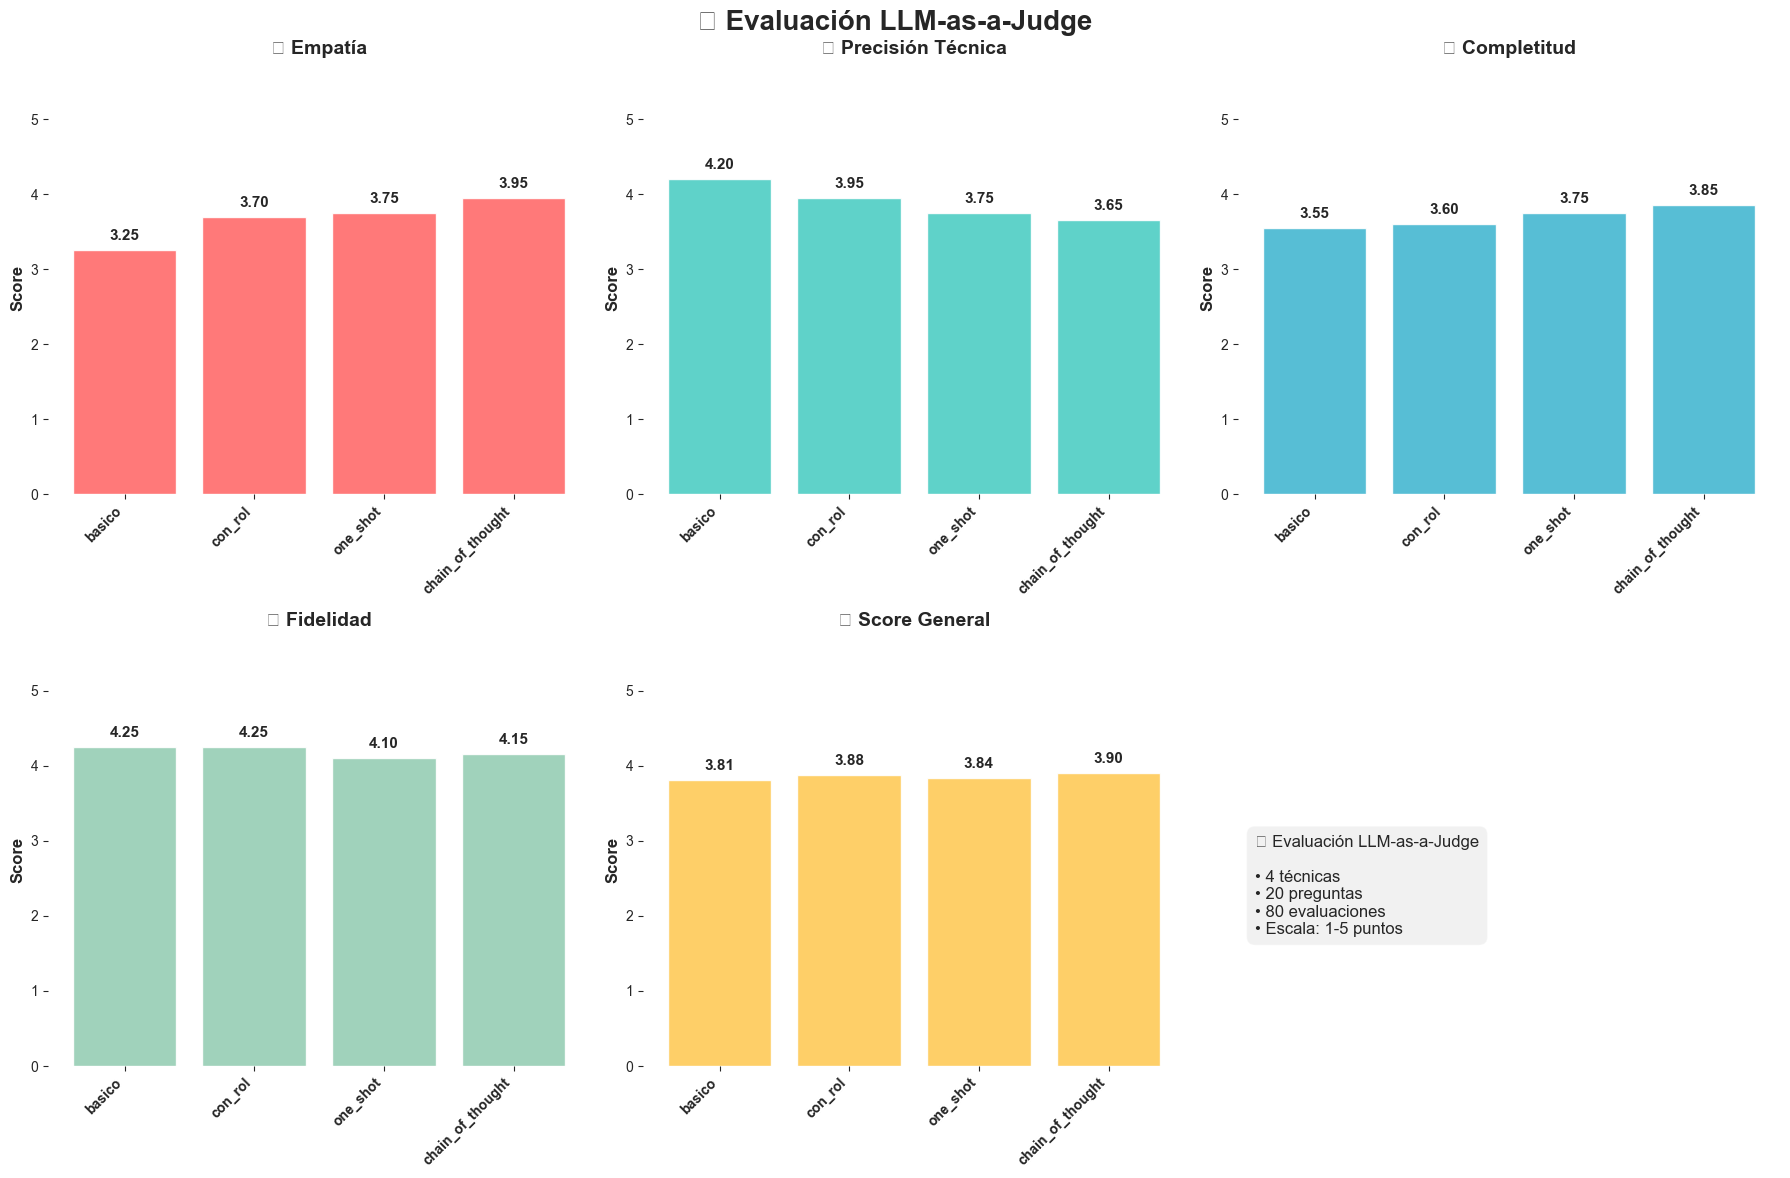

In [11]:
plt.style.use('default')
sns.set_style("white")

prompt_names = list(all_results.keys())
metrics = ['empathy_score', 'technical_accuracy_score', 'completeness_score', 'faithfulness_score', 'overall_score']
metric_labels = ['💝 Empatía', '🎯 Precisión Técnica', '✅ Completitud', '🔗 Fidelidad', '📋 Score General']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🚀 Evaluación LLM-as-a-Judge', fontsize=20, fontweight='bold', y=0.98)

axes_flat = axes.flatten()

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes_flat[i]
    
    prompt_averages = []
    for prompt_name in prompt_names:
        if metric == 'overall_score':
            scores = [r['overall_score'] for r in all_results[prompt_name]]
        else:
            scores = [r['evaluation'][metric] for r in all_results[prompt_name]]
        avg = sum(scores) / len(scores)
        prompt_averages.append(avg)
    
    bars = ax.bar(prompt_names, prompt_averages, color=colors[i], alpha=0.9)
    
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 5.5)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_xticklabels(prompt_names, rotation=45, ha='right', fontweight='bold')
    
    for bar, avg in zip(bars, prompt_averages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{avg:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=True, bottom=True, top=False, right=False)

axes_flat[5].set_visible(False)

fig.text(0.7, 0.25, f'📊 Evaluación LLM-as-a-Judge\n\n'
                    f'• {len(prompt_names)} técnicas\n'
                    f'• {len(all_results[prompt_names[0]])} preguntas\n'
                    f'• {len(prompt_names) * len(all_results[prompt_names[0]])} evaluaciones\n'
                    f'• Escala: 1-5 puntos',
         fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.1)
plt.show()

### 7.2 Métricas RAGAS

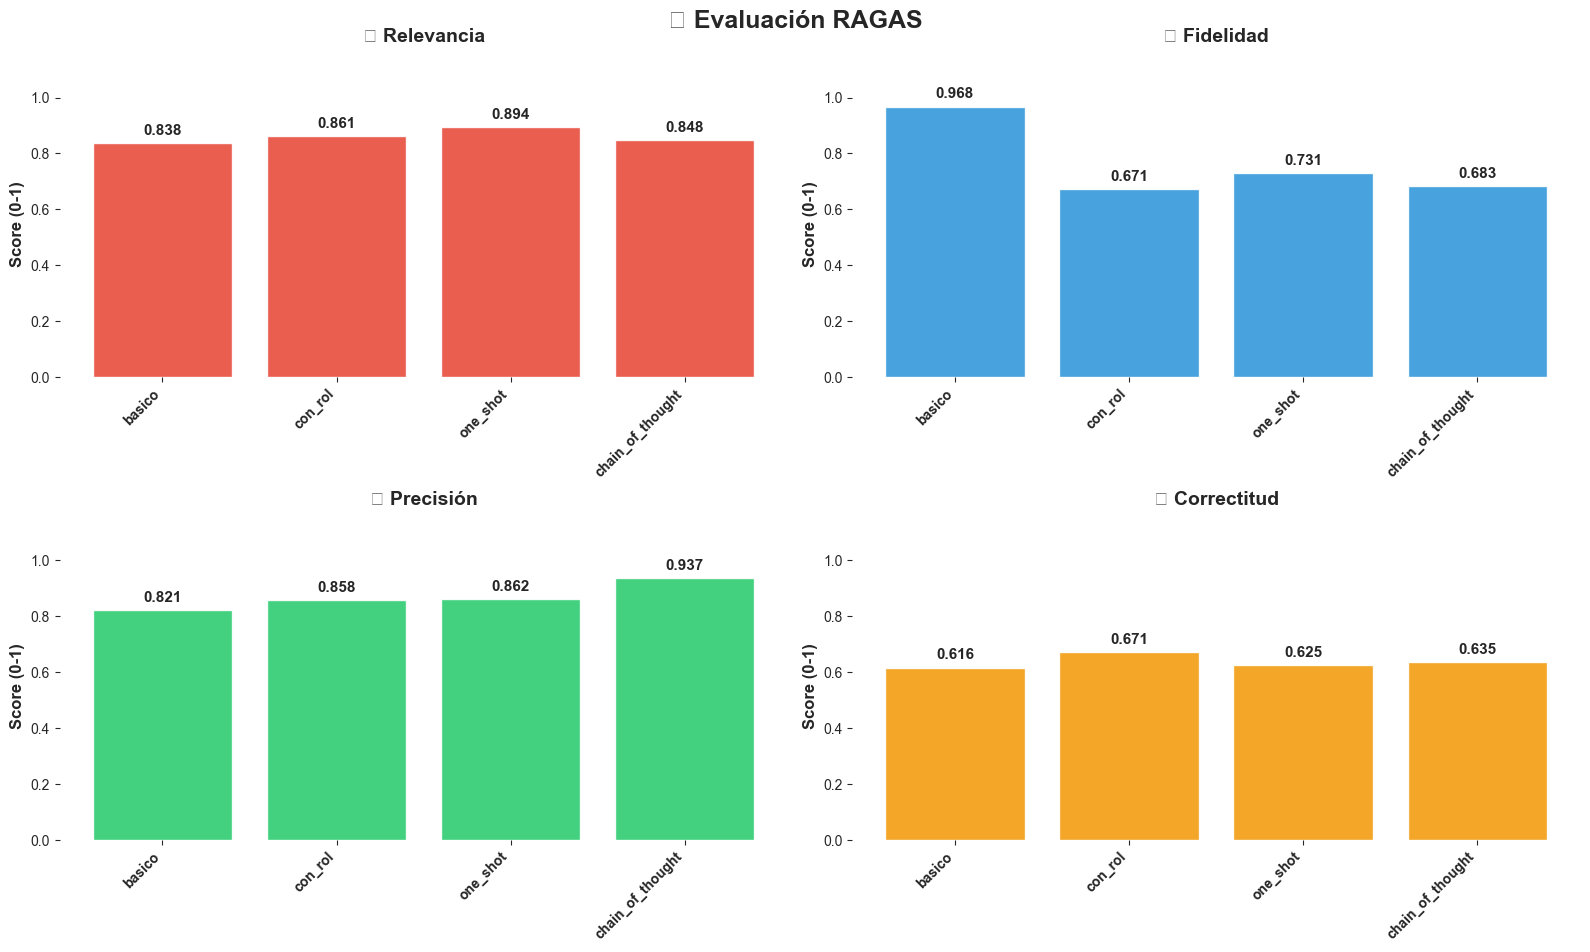


🏆 MEJORES POR MÉTRICA RAGAS:
📋 Relevancia: one_shot (0.894)
🔗 Fidelidad: basico (0.968)
🎯 Precisión: chain_of_thought (0.937)
✅ Correctitud: con_rol (0.671)


In [12]:
prompt_names = list(ragas_results.keys())
ragas_metrics = ['answer_relevancy', 'faithfulness', 'context_precision', 'answer_correctness']
ragas_labels = ['📋 Relevancia', '🔗 Fidelidad', '🎯 Precisión', '✅ Correctitud']
ragas_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📊 Evaluación RAGAS', fontsize=18, fontweight='bold', y=0.98)

axes_flat = axes.flatten()

for i, (metric, label) in enumerate(zip(ragas_metrics, ragas_labels)):
    ax = axes_flat[i]
    
    prompt_averages = [ragas_results[name][metric] for name in prompt_names]
    
    bars = ax.bar(prompt_names, prompt_averages, color=ragas_colors[i], alpha=0.9)
    
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
    ax.set_xticklabels(prompt_names, rotation=45, ha='right', fontweight='bold')
    
    for bar, avg in zip(bars, prompt_averages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{avg:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=True, bottom=True, top=False, right=False)

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.15)
plt.show()

print("\n🏆 MEJORES POR MÉTRICA RAGAS:")
print("="*40)
for metric, label in zip(ragas_metrics, ragas_labels):
    best = max(ragas_results.keys(), key=lambda p: ragas_results[p][metric])
    score = ragas_results[best][metric]
    print(f"{label}: {best} ({score:.3f})")

## 8. Conclusiones

Este notebook implementó una evaluación dual de técnicas de prompt engineering:

**LLM-as-a-Judge:** Evaluación semántica con métricas específicas para fintech (empatía, precisión técnica, completitud, fidelidad)

**RAGAS:** Framework estándar para sistemas RAG (relevancia, fidelidad, precisión de contexto, correctitud)

La evaluación dual permite:
- Validación cruzada de resultados
- Análisis desde múltiples perspectivas
- Mayor confiabilidad en la selección del mejor prompt

**Técnicas evaluadas:**
1. Prompt básico con contexto
2. Prompt con rol específico
3. One-shot learning
4. Chain-of-thought